In [176]:
#importing necessary libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


import random
import tensorflow as tf
# Set the seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
#reading in dataset 
df = pd.read_csv('final_df.csv')
df1 = df['close']

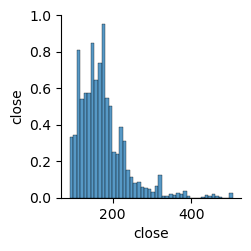

In [177]:
sns.pairplot(df)

In [178]:
df.head(100)

,close,date
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02
...,...,...
95,112.120,2015-10-09
96,111.600,2015-10-12
97,111.790,2015-10-13
98,110.210,2015-10-14


In [179]:
#LSTM's are sensitive to the scale of the data and because the distrbution is not Gaussian, MinMaxScaler wll be implemented 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

print(df1.shape)
print(df1)

(2456, 1)
[[0.10031269]
 [0.09967529]
 [0.09606735]
 ...
 [0.36084185]
 [0.35348166]
 [0.36440168]]


In [180]:
# splitting data into training and testing 
training_size = int(len(df1)*0.65)
test_size = len(df1) -training_size
train_data, test_data = df1[0:training_size],df1[training_size:len(df1),:1]

print(training_size, test_size)
#print(train_data, test_data)

1596 860


In [181]:
# convert an array of values into a dataset matrix 
def create_dataset(dataset,time_step =1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i +time_step,0])
    return np.array(dataX),np.array(dataY)

In [182]:
#Reshape into X = t, t+1, t+2,t+3 and Y= t+4 
time_step = 100
X_train, y_train= create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [183]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((1495, 100), (1495,), (759, 100), (759,))

In [184]:
# reshape the data 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape), print(X_test.shape)

(1495, 100, 1)
(759, 100, 1)


(None, None)

# Simple RNN

In [185]:
# importing libraries 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import SimpleRNN 


In [186]:
# initialising the model

rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
rnn_model.add(SimpleRNN(50, return_sequences=True))  
rnn_model.add(SimpleRNN(50)) 
rnn_model.add(Dense(1))
rnn_model.compile(loss="mean_squared_error", optimizer="adam",metrics = ['mae','mse'])

rnn_model.summary()


c:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_21 (SimpleRNN)       │ (None, 100, 50)        │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ (None, 100, 50)        │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

# 



In [187]:
# Building the model, RNN uses sigmoid and tanh as activation functions  
epochs_list = [10,20]
batch_size_list = [32,64]

results_rnn = {}

# loop over epochs and batch size 
for epochs in epochs_list:
    for batch_size in batch_size_list:
        print(f"Training with epochs = {epochs} and batch_size = {batch_size}")

        # fit the model
        history_rnn = rnn_model.fit(X_train,y_train, validation_data= (X_test,y_test),
                                epochs = epochs, batch_size = batch_size,verbose =1)

        val_loss_rnn = history_rnn.history['val_loss'][-1] #last epochs val loss

        results_rnn[(epochs,batch_size)] = val_loss_rnn

        print(f'Validation loss for epochs = {epochs}, batch_size = {batch_size}: {val_loss_rnn} ')

print("results_dictionary")
print(results_rnn)
 


Training with epochs = 10 and batch_size = 32
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0577 - mae: 0.1724 - mse: 0.0577 - val_loss: 7.9061e-04 - val_mae: 0.0257 - val_mse: 7.9061e-04
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - mae: 0.0189 - mse: 0.0014 - val_loss: 1.3134e-04 - val_mae: 0.0090 - val_mse: 1.3134e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.9379e-04 - mae: 0.0147 - mse: 9.9379e-04 - val_loss: 1.6122e-04 - val_mae: 0.0098 - val_mse: 1.6122e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.8777e-04 - mae: 0.0134 - mse: 8.8777e-04 - val_loss: 1.3711e-04 - val_mae: 0.0091 - val_mse: 1.3711e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.3462e-04 - mae: 0.0135 - mse: 8.3462e-04 - val_loss: 2.1983e-04 - val_mae: 0.0117 - val_mse: 2.1983e-04
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8289e-04 - mae: 0.0131 - mse: 7.8289e-04 - val_loss: 4.9302e-04 - val_mae: 0.0191 - 

In [188]:
#Return the best integer for number of epochs and batch size 
best_combination = min(results_rnn, key=results_rnn.get)
best_val_loss = results_rnn[best_combination]

print(f"The best combination is epochs={best_combination[0]}, batch_size={best_combination[1]} with validation loss {best_val_loss}")

The best combination is epochs=20, batch_size=64 with validation loss 9.60733596002683e-05


In [189]:
#fit model with best parameters 
rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, verbose=1)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.3361e-04 - mae: 0.0135 - mse: 5.3361e-04 - val_loss: 9.5427e-05 - val_mae: 0.0076 - val_mse: 9.5427e-05
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.9849e-04 - mae: 0.0119 - mse: 4.9849e-04 - val_loss: 1.2806e-04 - val_mae: 0.0090 - val_mse: 1.2806e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.1397e-04 - mae: 0.0140 - mse: 5.1397e-04 - val_loss: 8.6115e-05 - val_mae: 0.0072 - val_mse: 8.6115e-05
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.3109e-04 - mae: 0.0134 - mse: 5.3109e-04 - val_loss: 1.1394e-04 - val_mae: 0.0085 - val_mse: 1.1394e-04
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.8102e-04 - mae: 0.0116 - mse: 4.8102e-04 - val_loss: 1.3375e-04 - val_mae: 0.0092 - val_mse: 1.3375e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.5409e-04 - mae: 0.0120 - mse: 4.5409e-04 - val_loss: 9.5897e-05 - val_mae: 0.0077 - val_mse: 9.5897e-05
Epoch 7/20

# Results 
- Training Loss gradually decreased, with fluctuations between epochs:

- The loss started at 1.1389e-04 in Epoch 1, showing a general downward trend.

- The loss dropped to 9.5339e-05 by the end of Epoch 20.

- Training MAE fluctuated but showed overall improvement:

- The MAE started at 0.0075 in Epoch 1 and dropped to 0.0073 by Epoch 20.

- Training MSE decreased from 1.1389e-04 in Epoch 1 to 9.5339e-05 by Epoch 20.


- Although validation loss and MSE decreased initially, there were fluctuations, especially after Epoch 8, indicating potential overfitting or the need for further adjustments in model regularization.

In [190]:
# Running the predictions and checking the performance metrics 
train_predict = rnn_model.predict(X_train)

# Transform back to original scale 
train_predict = scaler.inverse_transform(train_predict)
test_predict = rnn_model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)



47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [191]:
# Importing libraries 
import math 
from sklearn.metrics import mean_squared_error

# Calculating the RMSE performance metrics 
math.sqrt(mean_squared_error(y_train, train_predict))  # Train data RMSE metrics 
math.sqrt(mean_squared_error(y_test, test_predict))  # Test data RMSE metrics

182.85486715643827

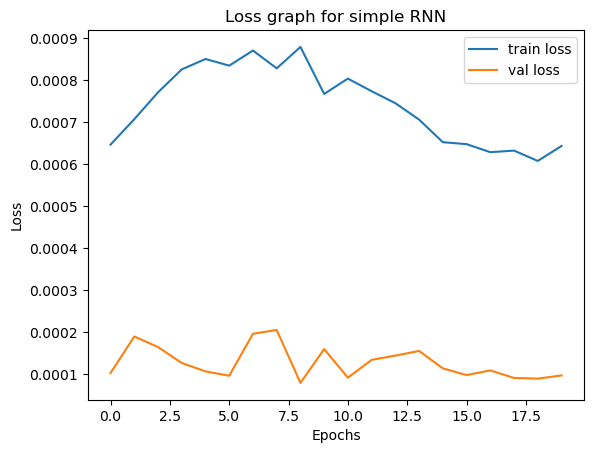

In [192]:
#Plotting the models loss 
plt.plot(history_rnn.history['loss'], label='train loss')
plt.plot(history_rnn.history['val_loss'], label='val loss')
plt.title('Loss graph for simple RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


 # Loss Graph interpretation 
 both the training loss and validation loss fluctuate while training a simple RNN, it generally suggests a few potential issues with the training process.

- Learning Rate Too High
- Vanishing/Exploding Gradients
- Inadequate Model Architecture (Simple RNN)
- Insufficient Epochs or Early Stopping

The model has been run many times over, this is the final run and it shows underfitting, more complexity will be added to the next model, LSTM with more layers 

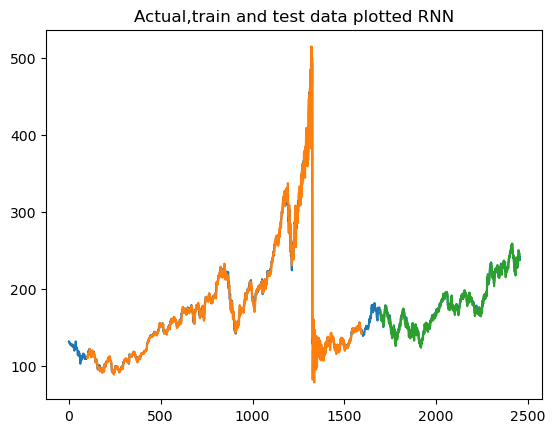

In [193]:
# Plotting
# Shift train predictions for plotting 
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting 
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1: len(df1) - 1, :] = test_predict

# Plot baseline and predictions 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Actual,train and test data plotted RNN')
plt.show()


In [194]:
# Calculate the last 100 days for prediction 
print(len(test_data))
X_input = test_data[760:].reshape(1, -1)
X_input.shape  # (1, 100)

# Convert it from an array to a list for plotting 
temp_input = list(X_input)
temp_input = temp_input[0].tolist()


860


In [195]:
# Demonstrating prediction for next 30 days

lst_output = []
n_steps = 100
i = 0
while(i < 30):
    if(len(temp_input) > 100):
        X_input = np.array(temp_input[1:])
        X_input = X_input.reshape(1, -1)
        X_input = X_input.reshape((1, n_steps, 1))
        yhat = rnn_model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        X_input = X_input.reshape((1, n_steps, 1))
        yhat = rnn_model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)

[[0.3661610186100006], [0.37651142477989197], [0.366353303194046], [0.3719410002231598], [0.3750624358654022], [0.38026952743530273], [0.38393867015838623], [0.38186776638031006], [0.3702218532562256], [0.3644176423549652], [0.3563002645969391], [0.3482546806335449], [0.34603777527809143], [0.34046515822410583], [0.3366803526878357], [0.32978835701942444], [0.3255653381347656], [0.32130613923072815], [0.32377713918685913], [0.32269883155822754], [0.31556227803230286], [0.30029812455177307], [0.29401153326034546], [0.2871435582637787], [0.2803868055343628], [0.26058515906333923], [0.2502676844596863], [0.2386109083890915], [0.23185154795646667], [0.2238052487373352]]


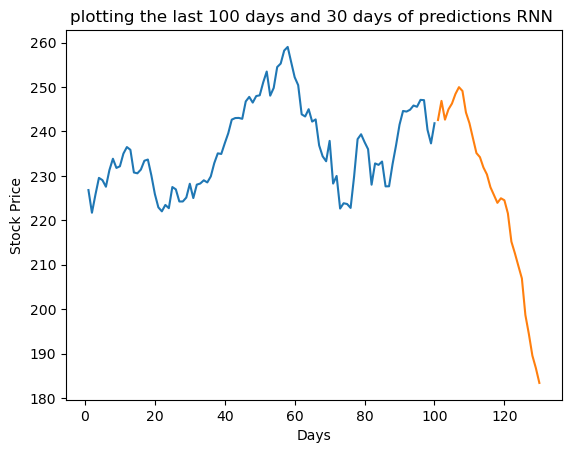

In [196]:
# Plotting the results
day_new = np.arange(1, 101)  
day_pred = np.arange(101, 131)
#Plotting the last 100 days and 30 days of predictions RNN
plt.plot(day_new, scaler.inverse_transform(df1[2356:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.title('plotting the last 100 days and 30 days of predictions RNN ')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()


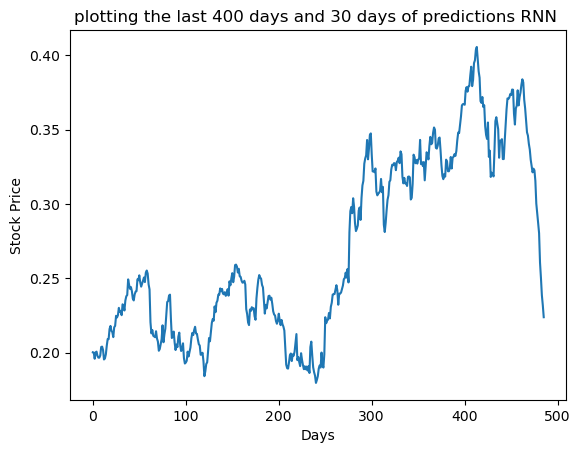

In [197]:
# Plotting the predicted values at the end of the original df 
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])
plt.title('plotting the last 400 days and 30 days of predictions RNN ')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()


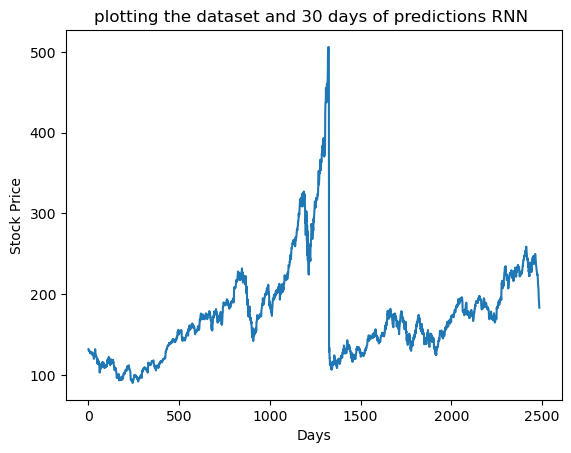

In [198]:
# Adding the whole df 
df3 = scaler.inverse_transform(df3).tolist()
plt.plot(df3)
plt.title('plotting the dataset and 30 days of predictions RNN ')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

In [199]:

# Now, access the first and last prediction from the test data

# Example for the first trading day price (index 0)
print("The first trading day price prediction for 24/9/2021 for RNN is: ", test_predict[0])

# The real first trading day price from the test_data (index 0)
print("The real first trading day price for 24/9/2021 for RNN is: ", scaler.inverse_transform(test_data[0:1])[0])

# Example for the last trading day price (index 20)
print("The last trading day price prediction for 24/9/2021 for RNN is: ", test_predict[20])

# The real last trading day price from the test_data (index 20)
print("The real last trading day price for 24/9/2021 for RNN is: ", scaler.inverse_transform(test_data[20:21])[0])


The first trading day price prediction for 24/9/2021 for RNN is:  [171.81743]
The real first trading day price for 24/9/2021 for RNN is:  [145.37]
The last trading day price prediction for 24/9/2021 for RNN is:  [156.16187]
The real last trading day price for 24/9/2021 for RNN is:  [148.64]
